<a href="https://colab.research.google.com/github/pouyashojaei/datathon-code/blob/Pouya/WiDS_Texas_jayeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS hackathon

Jayeon Kim

In [112]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dense, Flatten, LSTM, Conv2D
from tensorflow.keras import Model, Sequential

file_north = 'north_electricity_weather_history.csv'
file_south_central = 'south_central_electricity_weather_history.csv'

files = [file_north, file_south_central]
dfs = [pd.read_csv(file) for file in files]

for df in dfs:
  df.drop_duplicates(subset = "index", keep = 'first', inplace = True) #drop duplicate rows
  df['Month'] = pd.DatetimeIndex(df['index']).month
  #df['Day'] = pd.DatetimeIndex(df['index']).day
  df['Hour'] = pd.DatetimeIndex(df['index']).hour
  df[['Hour', 'Month']] = df[['Hour', 'Month']].astype('category')

## What does the data look like?

### Last four weeks

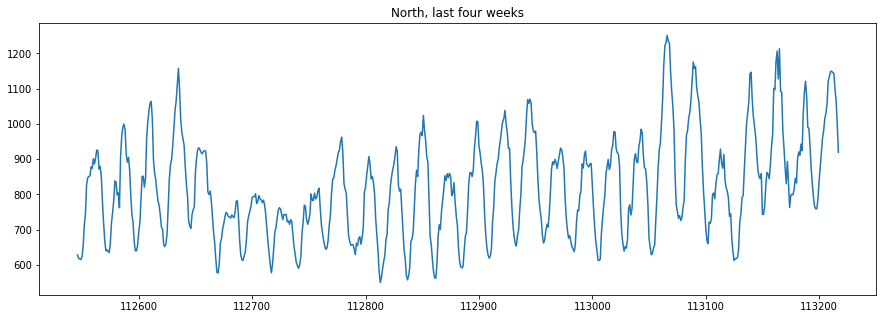

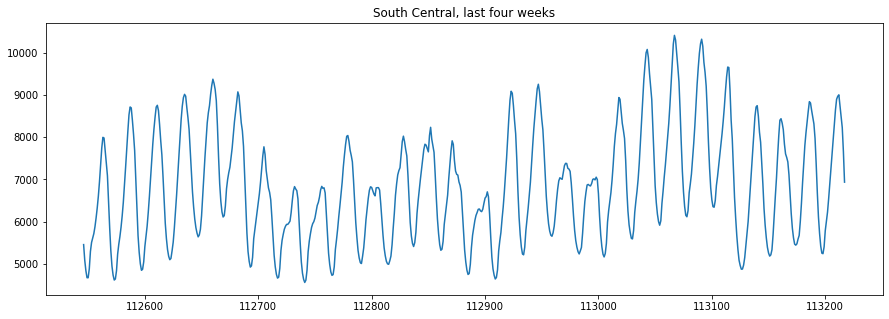

In [113]:
for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)

  t = 24 * 7 * 4 #24 hours, seven days, four weeks
  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, last four weeks')
  plt.plot(df.iloc[-t:,0])
  plt.show()

The pattern of electricity consumption is generally similar for both regions, but the level of electricity consumption is significantly higher in the South Central region.

### For the month of June

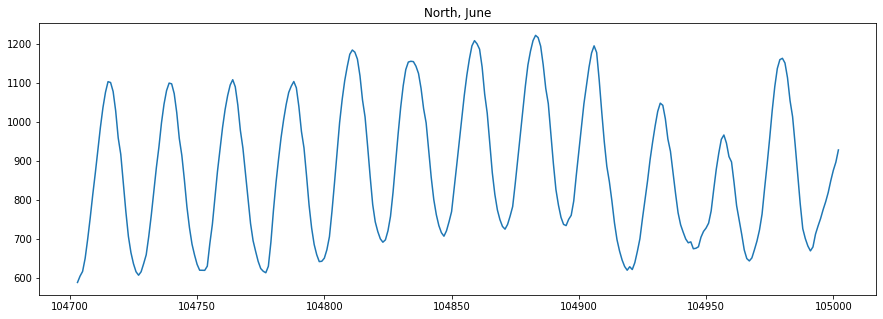

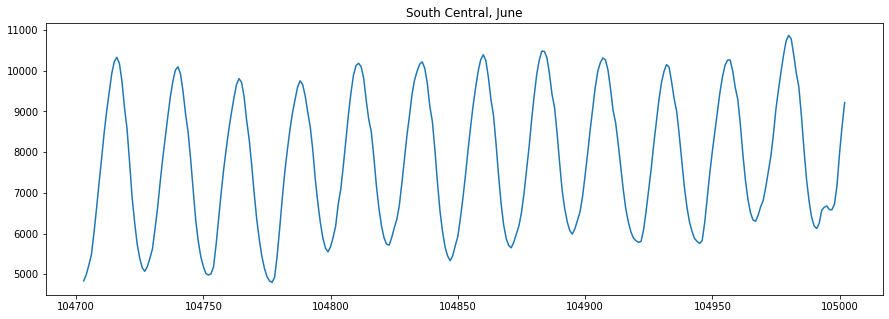

In [114]:
for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)

  plt.figure(figsize=(15,5))
  plt.title(f'{df.columns[0]}, June')
  plt.plot(df[df['Month'] == 6].iloc[-500:-200,0])
  plt.show()

## Feature selection
### Part 1: Which features are correlated with which?
Now let us do some feature selection using the correlation matrix.

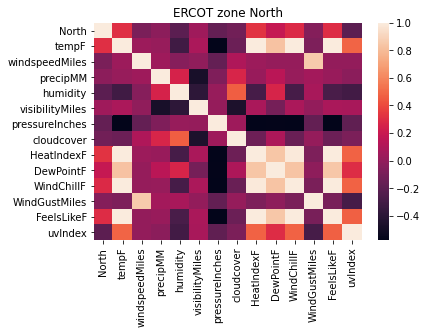

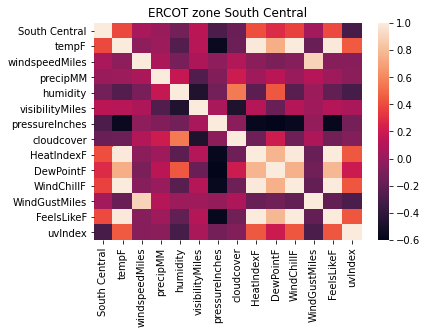

In [115]:
def view_heatmap(df):
  corr = df.corr()
  
  plt.figure()
  plt.title(f'ERCOT zone {df.columns[0]}')
  sns.heatmap(corr)
  plt.show()

for df in dfs:
  df = df.reset_index()
  df = df.drop(['level_0', 'index'], axis=1)
  
  view_heatmap(df)


Looking at the heatmaps for three ERCOT zones, we see that the correlation of predictor features and the target feature is not the same for every ERCOT zone. Generally, the correlation between the target feature and predictor features appears weaker in ERCOT zones located in the west. Perhaps this is because western Texas is less susceptible to extreme weather? (compared to coastal Texas that would see a lot of hurricanes). 

Generally, features with stronger correlation appear to be tempF, HeatIndexF, DewPointF, WindChillF and FeelsLikeF, whereas there appears to be a strong negative correlation between electricity demand and uvIndex. This is likely because electricity supply levels sharply decrease during nighttime (when UV levels are lower).

### Part 2: Check for low-variance features
I checked to see whether any low-variance features could be removed from the data.

In [116]:
def view_variance_threshold(df):
  X = pd.DataFrame(df.iloc[:,1:])
  y = pd.DataFrame(df.iloc[0])
  
  sel = VarianceThreshold(threshold=.5)
  sel.fit_transform(X)
  to_remove = X.columns[(np.where(sel.get_support() == False))]
  return list(to_remove)

for df in dfs:
  #df = df.drop(['level_0', 'index'], axis=1)
  print(f'ERCOT weather zone: {df.columns[0]}')
  print(f'Low-variance feature(s): {view_variance_threshold(df)} \n')

ERCOT weather zone: index
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: index
Low-variance feature(s): ['pressureInches'] 



For most ERCOT weather zones, pressureInches is a low-variance feature, so the feature will be removed from the data before modelling.

## Modelling

ERCOT weather region North
Epoch 1/5
108/108 [==============================] - 38s 32ms/step - loss: 0.0191 - val_loss: 0.0112
Epoch 2/5
108/108 [==============================] - 3s 29ms/step - loss: 0.0041 - val_loss: 0.0133
Epoch 3/5
108/108 [==============================] - 3s 29ms/step - loss: 0.0054 - val_loss: 0.0170
Epoch 4/5
108/108 [==============================] - 3s 28ms/step - loss: 0.0046 - val_loss: 0.0214
Epoch 5/5
108/108 [==============================] - 3s 31ms/step - loss: 0.0053 - val_loss: 0.0324


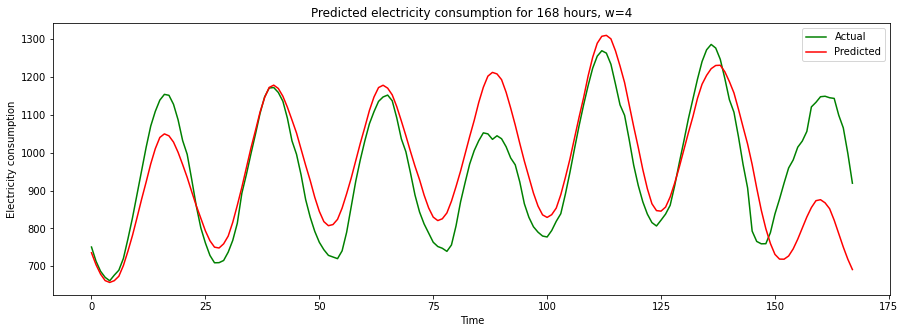

Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.0456 - val_loss: 0.0242
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0288 - val_loss: 0.0170
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0046 - val_loss: 0.0086
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0056 - val_loss: 0.0092


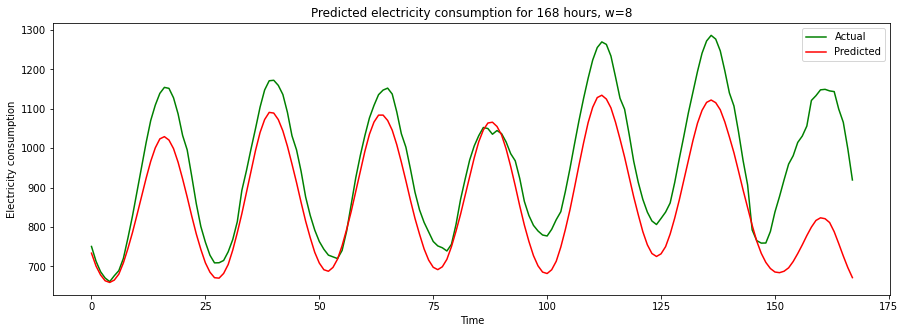

Epoch 1/5
323/323 [==============================] - 13s 31ms/step - loss: 0.0129 - val_loss: 0.0071
Epoch 2/5
323/323 [==============================] - 10s 30ms/step - loss: 0.0051 - val_loss: 0.0080
Epoch 3/5
323/323 [==============================] - 10s 30ms/step - loss: 0.0058 - val_loss: 0.0122
Epoch 4/5
323/323 [==============================] - 10s 30ms/step - loss: 0.0061 - val_loss: 0.0147
Epoch 5/5
323/323 [==============================] - 10s 30ms/step - loss: 0.0053 - val_loss: 0.0124


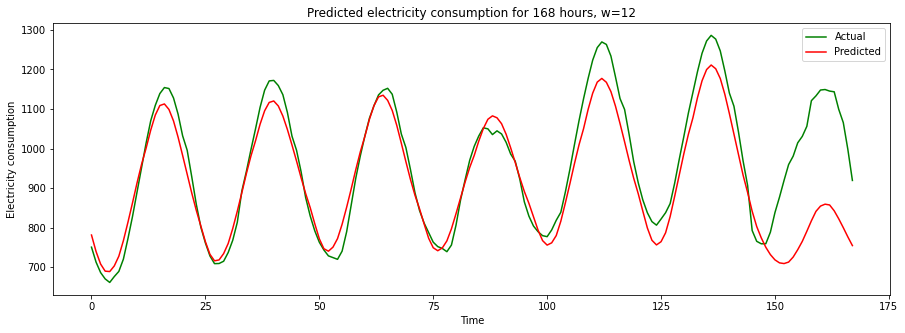

Epoch 1/5
430/430 [==============================] - 12s 24ms/step - loss: 0.0162 - val_loss: 0.0076
Epoch 2/5
430/430 [==============================] - 10s 24ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 3/5
430/430 [==============================] - 10s 23ms/step - loss: 0.0048 - val_loss: 0.0084
Epoch 4/5
430/430 [==============================] - 10s 23ms/step - loss: 0.0048 - val_loss: 0.0108
Epoch 5/5
430/430 [==============================] - 10s 23ms/step - loss: 0.0047 - val_loss: 0.0115


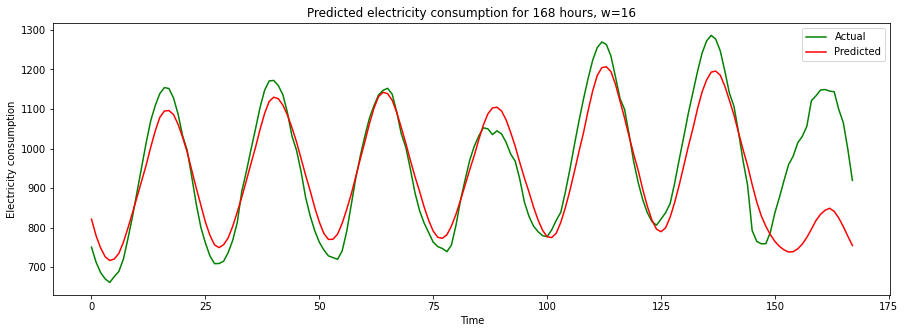

Epoch 1/5
 89/538 [===>..........................] - ETA: 12s - loss: 0.0197

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

def test_time_steps(df, t=24, w=4):
  n_rows, n_cols = df.shape
  train = df.iloc[:-200,:]
  test = df.iloc[-(200+t):] #is the size important?

  min_max_scaler = MinMaxScaler(feature_range=(0,1))
  train_scaled = min_max_scaler.fit_transform(train)
  train_scaled = pd.DataFrame(train_scaled)
  
  test_scaled = min_max_scaler.fit_transform(test)
  test_scaled = pd.DataFrame(test_scaled)

  X_test = pd.DataFrame(test_scaled.iloc[:, 1:])
  y_test = pd.DataFrame(test_scaled.iloc[:, 0])
  X_test.columns = test.columns[1:] #name the columns
  y_test.columns = test.columns[:1] #name the columns

  X_train = pd.DataFrame(train_scaled.iloc[:, 1:])
  y_train = pd.DataFrame(train_scaled.iloc[:, 0])
  X_train.columns = train.columns[1:] #put back the column names
  y_train.columns = train.columns[:1]

  X_train_steps, y_train_steps = create_dataset(X_train, y_train, t)
  X_test_steps, y_test_steps = create_dataset(X_test, y_test, t)

  model = Sequential()
  model.add(LSTM(units=100,
                 activation='relu',
                 return_sequences=True, 
                 input_shape=(X_train_steps.shape[1], 
                              X_train_steps.shape[2])))
  model.add(LSTM(units=100, activation='relu'))
  model.add(Dense(1))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(0.001))

  steps = 24 * 7 * w
  history = model.fit(
      X_train_steps[len(X_train_steps)-steps:,:], 
      y_train_steps[len(y_train_steps)-steps:],
      epochs=5,
      batch_size=5,
      validation_split=0.2,
      verbose=1,
      shuffle=False)

  y_pred = model.predict(X_test_steps)
  n_rows, _, n_features = X_test_steps.shape
  #n_features = X_test_steps.shape[2]

  predicted_np = np.column_stack((y_pred, 
                                  np.ones((n_rows, n_features)) ))
  predicted_inverse = min_max_scaler.inverse_transform(predicted_np)

  actual_np = np.column_stack((y_test_steps, 
                               np.ones((n_rows, n_features)) ))
  actual_inverse = min_max_scaler.inverse_transform(actual_np)

  return actual_inverse, predicted_inverse
  
df_north = dfs[0].reset_index()
df_north = df_north.drop(['level_0', 
                          'index'], axis=1) #dropped some low-correlation features
#df_north = df_north[df_north['Month'] == 6] #only get data for the month of June
print(f'ERCOT weather region {df_north.columns[0]}')
to_drop = view_variance_threshold(df_north)
df_north = df_north.drop(to_drop, axis=1)

weeks = [4,8,12,16,20]
for week in weeks:
  actual, predicted = test_time_steps(df_north, t=24, w=week)

  plt.figure(figsize=(15,5))
  plt.plot(actual[-168:,0], color='green', label = 'Actual')
  plt.plot(predicted[-168:,0], color='red', label = 'Predicted')
  plt.title(f'Predicted electricity consumption for 168 hours, w={week}')
  plt.xlabel('Time')
  plt.ylabel('Electricity consumption')
  plt.legend()
  plt.show()

ERCOT weather region South Central
Epoch 1/5
112/112 [==============================] - 6s 30ms/step - loss: 0.0189 - val_loss: 0.0177
Epoch 2/5
112/112 [==============================] - 3s 27ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 3/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 4/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 5/5
112/112 [==============================] - 3s 28ms/step - loss: 0.0070 - val_loss: 0.0026


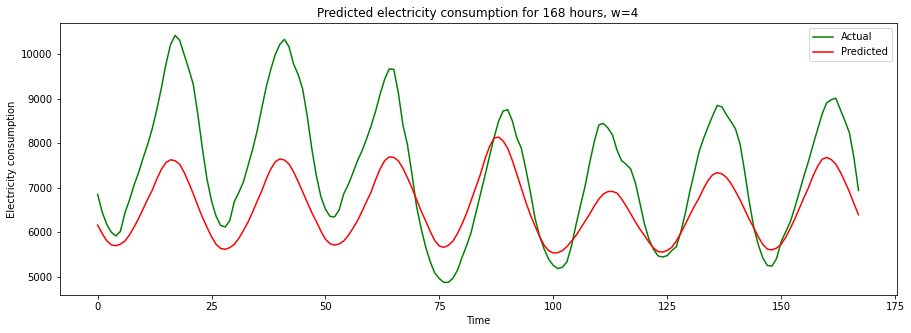

Epoch 1/5
165/165 [==============================] - 6s 24ms/step - loss: 0.0098 - val_loss: 0.0246
Epoch 2/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0068 - val_loss: 0.0169
Epoch 3/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 4/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 5/5
165/165 [==============================] - 4s 22ms/step - loss: 0.0043 - val_loss: 0.0074


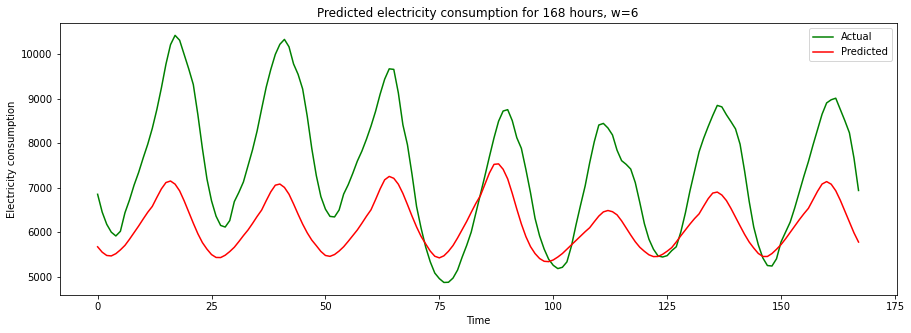

Epoch 1/5
219/219 [==============================] - 9s 31ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 2/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 3/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0039 - val_loss: 0.0095
Epoch 4/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 5/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0036 - val_loss: 0.0037


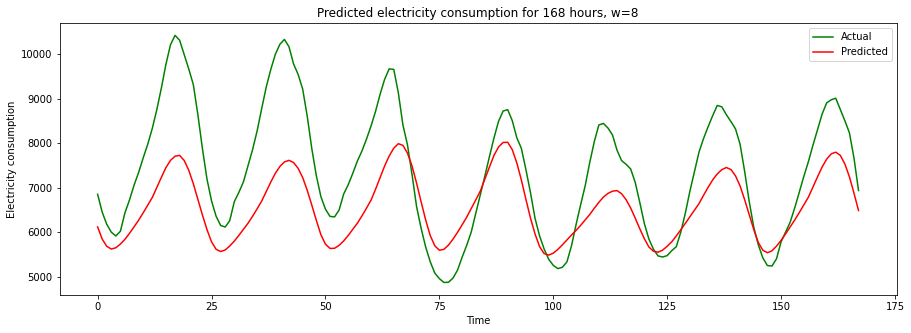

Epoch 1/5
273/273 [==============================] - 11s 31ms/step - loss: 0.0066 - val_loss: 0.0101
Epoch 2/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0047 - val_loss: 0.0078
Epoch 3/5
273/273 [==============================] - 8s 30ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 4/5
273/273 [==============================] - 8s 29ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 5/5
273/273 [==============================] - 8s 29ms/step - loss: 0.0039 - val_loss: 0.0064


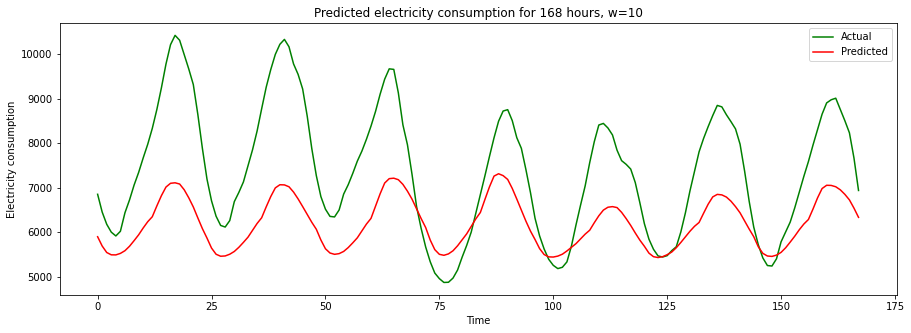

In [118]:
df_sc = dfs[1].reset_index()
df_sc = df_sc.drop(['level_0', 
                    'index', 
                    'visibilityMiles'], axis=1)
#df_sc = df_sc[df_sc['Month'] == 6]
print(f'ERCOT weather region {df_sc.columns[0]}')
to_drop = view_variance_threshold(df_sc)
df_sc = df_sc.drop(to_drop, axis=1)

weeks = [4,6,8,10]
for week in weeks:
  actual, predicted = test_time_steps(df_sc, t=24, w=week)

  plt.figure(figsize=(15,5))
  plt.plot(actual[-168:,0], color='green', label = 'Actual')
  plt.plot(predicted[-168:,0], color='red', label = 'Predicted')
  plt.title(f'Predicted electricity consumption for 168 hours, w={week}')
  plt.xlabel('Time')
  plt.ylabel('Electricity consumption')
  plt.legend()
  plt.show()